In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import gc

from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')
print(train.shape)
print(test.shape)

sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
print(sub.shape)
labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
print('label', labels.shape)

(1558080, 16)
(733080, 16)
(12218, 2)
label (25968, 2)


In [3]:
features = [c for c in train.columns if 'sensor' in c]

# adding labels to train data
train = pd.merge(train, labels,how='left', on="sequence")
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,state
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492,0
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390,0
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147,0
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241,0
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359,0


# FE

In [4]:
def addFeatures(df):  
    
    for f in features:
        df[f + '_lag1'] = df.groupby('sequence')[f].shift(1).fillna(0).astype('float32')
        
        #df[f + '_lag_back1'] = df.groupby('sequence')[f].shift(-1).fillna(0).astype('float32')
        #df[f + '_cumsum'] = df.groupby('sequence')[f].cumsum().astype('float32')
        df[f + '_diff1'] = (df[f] - df[f + '_lag1']).astype('float32')
    return df

train = addFeatures(train)
test = addFeatures(test)

print(train.shape)
print(test.shape)
train.head()

(1558080, 43)
(733080, 42)


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,...,sensor_08_lag1,sensor_08_diff1,sensor_09_lag1,sensor_09_diff1,sensor_10_lag1,sensor_10_diff1,sensor_11_lag1,sensor_11_diff1,sensor_12_lag1,sensor_12_diff1
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,...,0.0,-0.1,0.000000,-0.963873,0.000000,-0.985069,0.000000,0.531893,0.000000,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,...,-0.1,0.3,-0.963873,0.662572,-0.985069,1.067802,0.531893,-0.763375,4.751492,-4.297101
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,...,0.2,1.2,-0.301301,1.303468,0.082733,0.366488,-0.231481,-0.354938,0.454390,-5.190537
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,...,1.4,-1.7,1.002168,-1.997832,0.449221,-0.883511,-0.586420,1.931070,-4.736146,5.165388
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,...,-0.3,-0.6,-0.995665,2.051301,-0.434290,1.246921,1.344650,-1.221193,0.429241,-0.652600


In [5]:
Window = 60

groups = train["sequence"]
#labels = labels["state"]

y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
groups.unique()

array([    0,     1,     2, ..., 25965, 25966, 25967])

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
sc = StandardScaler()

train = sc.fit_transform(train)
test = sc.transform(test)

In [8]:
train = train.reshape(-1, Window, train.shape[-1])
test = test.reshape(-1, Window, train.shape[-1])
print(train.shape)

(25968, 60, 39)


In [9]:
import tensorflow as tf
import logging
from tensorflow.keras import *

2022-04-08 03:26:19.205013: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-08 03:26:19.205153: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# Detect hardware, return appropriate distribution strategy
print(tf.version.VERSION)
tf.get_logger().setLevel(logging.ERROR)
try: # detect TPU
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPU(s) and enable mixed precision
    strategy = tf.distribute.MirroredStrategy() # works on GPU and multi-GPU
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')
print("REPLICAS: ", strategy.num_replicas_in_sync)

2.4.1


2022-04-08 03:26:23.563392: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 03:26:23.569776: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-08 03:26:23.569808: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-08 03:26:23.569858: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6ec746e1712d): /proc/driver/nvidia/version does not exist
2022-04-08 03:26:23.573409: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS:  8


# LSTM

In [11]:
def plotHist(hist):
    plt.plot(hist.history["auc"])
    plt.plot(hist.history["val_auc"])
    plt.title("model performance")
    plt.ylabel("area_under_curve")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [12]:
from tensorflow.keras.metrics import AUC

def createModel():
    with strategy.scope():
        model = Sequential(
        [
            Input(shape = (Window, train.shape[-1])),
            Bidirectional(LSTM(768, return_sequences = True)),
            Bidirectional(LSTM(512, return_sequences = True)), 
            Bidirectional(LSTM(256, return_sequences = True)),
            Bidirectional(LSTM(128, return_sequences = True)),
            Bidirectional(LSTM(128, return_sequences = True)),
            Dense(128, activation = 'selu'),
            Dense(1, activation = 'sigmoid')
        ]
        )
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [AUC(name = 'auc')]
                     )
    return (model)

fold 1
************************************************************
82/82 [==============================] - 49s 285ms/step - loss: 0.6736 - auc: 0.6108 - val_loss: 1.0322 - val_auc: 0.4557
##############################
Fold-1 | OOF Score: 0.4558467654431039


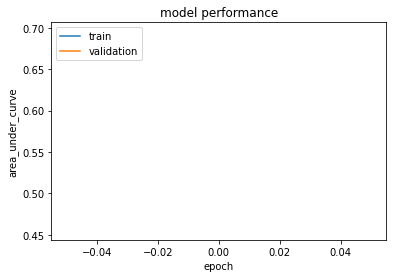

fold 2
************************************************************
82/82 [==============================] - 52s 293ms/step - loss: 0.6839 - auc: 0.5948 - val_loss: 0.5926 - val_auc: 0.7729
##############################
Fold-2 | OOF Score: 0.7729133040114927


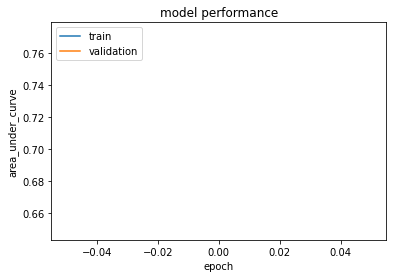

fold 3
************************************************************
82/82 [==============================] - 54s 313ms/step - loss: 0.6758 - auc: 0.6101 - val_loss: 0.5095 - val_auc: 0.8345
##############################
Fold-3 | OOF Score: 0.8345108503731894


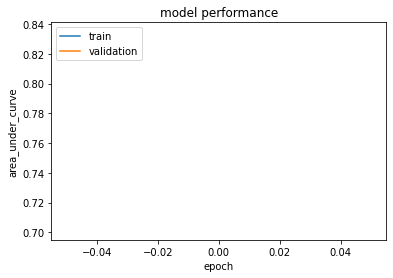

fold 4
************************************************************
82/82 [==============================] - 52s 303ms/step - loss: 0.6769 - auc: 0.6149 - val_loss: 0.5972 - val_auc: 0.8057
##############################
Fold-4 | OOF Score: 0.8057175873181969


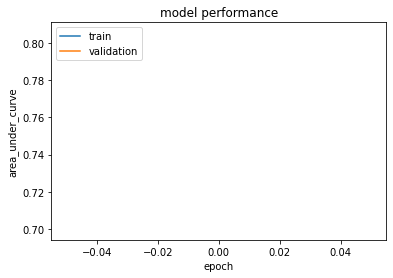

fold 5
************************************************************
82/82 [==============================] - 52s 307ms/step - loss: 0.6762 - auc: 0.6053 - val_loss: 0.5655 - val_auc: 0.7885
##############################
Fold-5 | OOF Score: 0.7885143362328626


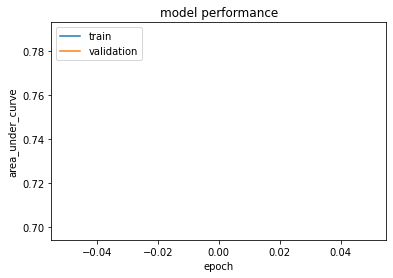

CPU times: user 2min 32s, sys: 11.6 s, total: 2min 43s
Wall time: 6min 6s


In [13]:
%%time


from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import *

skf = KFold(n_splits = 5, shuffle = True, random_state = 2022)
gkf = GroupKFold(n_splits = 5)
preds = []

BATCH_SIZE = 256

for fold, (train_idx, val_idx) in enumerate(gkf.split(train, y, groups.unique())):
    print('fold', fold+1)
    print('*'*60)
    groups.unique()
    X_train, X_valid = train[train_idx], train[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]
    
    es = EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 5, verbose = 1, restore_best_weights = True)
    lr = ReduceLROnPlateau(monitor="val_auc", factor=0.8, 
                               patience=4, verbose = 1)
    model = createModel()
    
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                       epochs = 1, batch_size = 256, callbacks = [es, lr])
    
    y_true = y_valid.squeeze().reshape(-1, 1)
    y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
    score = roc_auc_score(y_true, y_pred)
    
    print('#'*30)
    print(f"Fold-{fold+1} | OOF Score: {score}")
    
    preds.append(model.predict(test).squeeze())
    plotHist(history)
    
    del X_train, X_valid, y_train, y_valid, model, history
    gc.collect()
    

# Submission

In [14]:
sub["state"] = sum(preds)/skf.n_splits 
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,0.725182
1,25969,0.600109
2,25970,0.391383
3,25971,0.374868
4,25972,0.646484
...,...,...
12213,38181,0.548567
12214,38182,0.543861
12215,38183,0.437171
12216,38184,0.487063
